In [24]:
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
import time
import copy
import math
import numpy as np
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState

""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient  
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
import sys
""" FOR UR5 """
import sys
sys.path.append('../../')
from model.gripper import openGrasp, closeGrasp, resetTool
from model.RealRobot import RealRobot

### Parsing Mujoco env

In [25]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
print ("MuJoCo version:[%s]"%(mujoco.__version__))

xml_path = '../../asset/ur5e/scene_ur5e_realworld.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
# env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
print ("Ready.")

joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))

MuJoCo version:[2.3.5]
dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cyli

### Instantiate Real UR robot

In [26]:
rospy.init_node('Pick_n_Place')
real_robot = RealRobot()

### Set to Initial Pose

In [28]:
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
q = copy.deepcopy(capture_q)
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(7.0)

q_traj.points.append(point)
real_robot.execute_arm_speed(q_traj, speed_limit=1.0)
real_robot.client.wait_for_result()

Waiting for server...
Connected to server
[array([-1.89, -1.27,  2.03, -0.76,  1.25, -0.  ]), array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57])]
[-1.57 -2.31  2.14  1.74  0.79 -1.57] [-1.89 -1.27  2.03 -0.76  1.25 -0.  ]
diff_q:[ 0.32 -1.04  0.11  2.5  -0.47 -1.57]
diff_time:7.0
0.4543085456575639
Finish plan


True

### `Perception`: table scene

In [5]:
#%%
from demo_realworld_perception import run_camera, project_XY, project_YZ, cluster_info_2_cleaned_point_cloud
from demo_realworld_perception import Translation, Rotation_X, Rotation_Y, HT_matrix

rotation_x   = Rotation_X(-math.pi)
rotation_y   = Rotation_Y(-math.pi/4)
rotation_mat = np.dot(rotation_x, rotation_y)
position_mat = Translation(0.454,0,1.3)

env.forward(q=capture_q,joint_idxs=idxs_forward)
print(env.get_q(joint_idxs=idxs_jacobian))
p_cam = env.get_p_body("camera_center") - env.get_p_body("base") + np.array([-0.03, 0.03,0])
R_world = env.get_R_body('camera_center')

rotation_mat = np.eye(4)
Transform_rel = rpy2r(np.array([0, -0.5, -0.5])*np.pi)
rotation_mat[:3,:3] =  R_world @ Transform_rel

VIZ = True
perception_path = "/home/rilab-ur/UnseenObjectClustering"


[-1.57 -2.31  2.14  1.74  0.79 -1.57]


In [6]:
rotation_x   = Rotation_X(-math.pi)
rotation_y   = Rotation_Y(-math.pi/4)
rotation_mat = np.dot(rotation_x, rotation_y)
p_cam = np.array([0.454,0,1.3])
position_mat = Translation(0.454,0,1.3)
transform_mat= HT_matrix(rotation_mat, position_mat)

cleaned_point_cloud_list = run_camera(perception_path, camera_p = p_cam, rotation_mat=rotation_mat, clean_scale=3)

+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ export CUDA_VISIBLE_DEVICES=0
+ CUDA_VISIBLE_DEVICES=0
+ outdir=data/checkpoints
+ ./ros/test_images_segmentation.py --gpu 0 --network seg_resnet34_8s_embedding --pretrained data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth --pretrained_crop data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth --cfg experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Called with args:
Namespace(background_name=None, cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', gpu_id=0, instance_id=0, network_name='seg_resnet34_8s_embedding', pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', randomize=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TRAIN',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/rilab-ur/UnseenObjectClustering',
 'TEST': {'ALIGN_Z_AXIS': 

/home/rilab-ur/.local/lib/python3.8/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/rilab-ur/.local/lib/python3.8/site-packages/torch/nn/functional.py:4014: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


4 objects
num_object 4


In [7]:
label_pixel = np.load(f'{perception_path}/label_data.npy')
depth_pixel = np.load(f'{perception_path}/depth_data.npy') 
rbg_pixel = np.load(f'{perception_path}/rgb_data.npy')

position_mat = Translation(*(p_cam.tolist()))
transform_mat= HT_matrix(rotation_mat, position_mat)

cleaned_point_cloud = cluster_info_2_cleaned_point_cloud(label_pixel, depth_pixel, transform_mat, clean_scale=3)

### Hough Transform

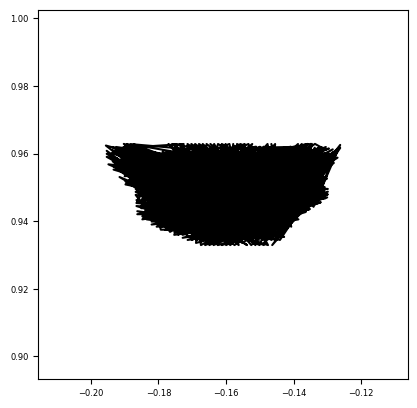

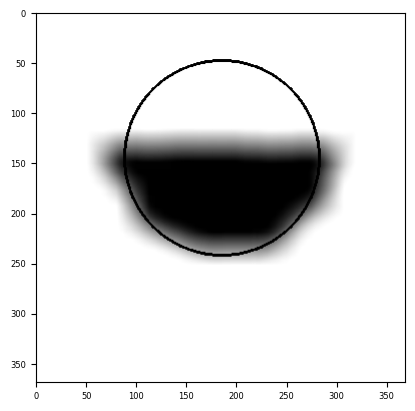

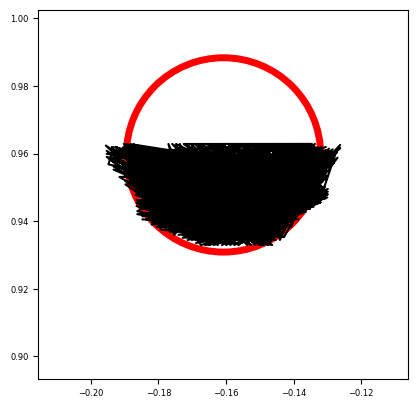

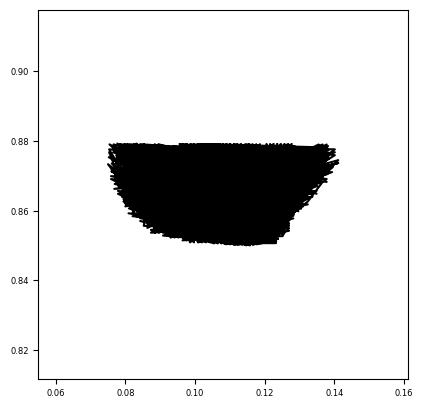

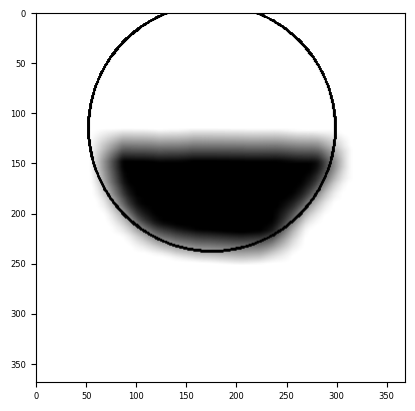

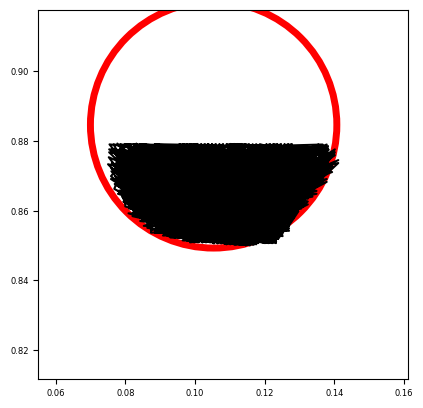

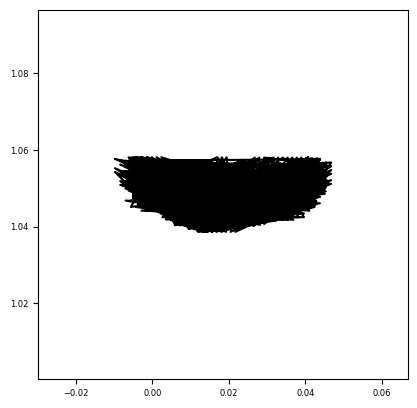

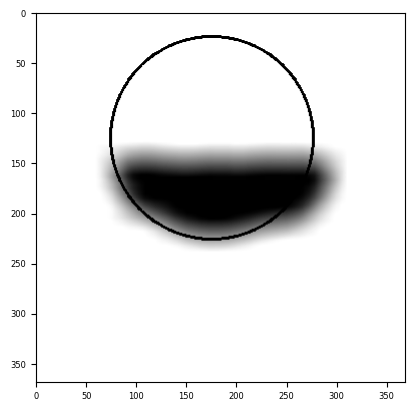

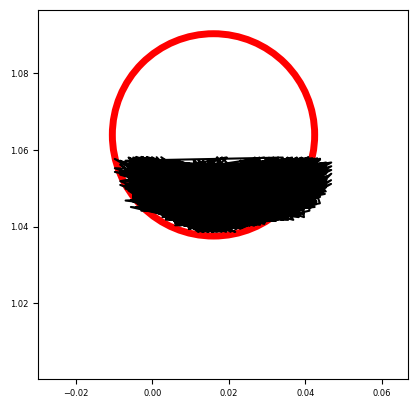

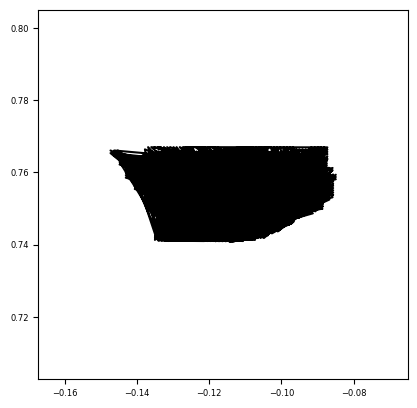

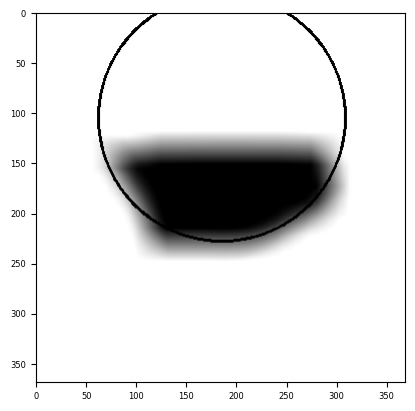

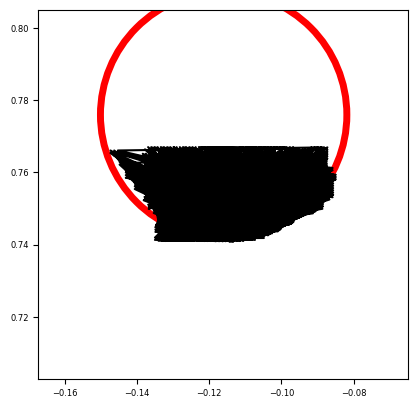

In [9]:
edge = 0.01

def detect_hough(image_path):
    import cv2
    import numpy as np

    # Load image
    partial_image = cv2.imread(image_path, 0)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(partial_image, (33,33), 250)

    dp = 10.0  # Inverse ratio of the accumulator resolution to the image resolution (1 means same resolution)
    min_dist = 500  # Minimum distance between the centers of the detected circles
    param1 = 10  # Upper threshold for the internal Canny edge detector
    param2 = 5  # Threshold for center detection (lower value for more circles)
    min_radius = 70  # Minimum circle radius
    max_radius = 140  # Maximum circle radius (0 for no limit)

    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, min_dist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)


    # Draw detected circles on the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(blurred_image, center, radius, (0, 255, 0), 2)
    else: print("No Circles!")

    # Display the result
    plt.imshow(blurred_image, cmap='gray')
    return partial_image, center, radius

# the z_value of the objects are same with 0.81
z_hard = 0.81
edge = 0.02

center_position_list = []
for cleaned_point_cloud in cleaned_point_cloud_list:
    image_path = "XY.png"
    ax, fig, XY_info = project_XY(cleaned_point_cloud, edge, SAVE=image_path)
    plt.show()

    partial_image, center_pixel, radius_pixel = detect_hough("XY.png")
    scale_rate = 2*(XY_info['radius']+XY_info['edge'])/partial_image.shape[0]

    center_x = center_pixel[0] * scale_rate + XY_info['center_x'] - (XY_info['radius']+edge)
    center_y = -1 * center_pixel[1] * scale_rate + XY_info['center_y'] + (XY_info['radius']+edge)
    radius = radius_pixel * scale_rate

    ax, fig, XY_info = project_XY(cleaned_point_cloud, edge=edge, SAVE=None)
    circle = plt.Circle((center_x, center_y), radius, fill=False, color='r', lw=5)
    ax.add_artist(circle)
    plt.show()

    center_position_list.append(np.array([center_y, center_x, z_hard]))


### Visualize segmented pointcloud

In [10]:
import pyvista as pv
# visualize segmented point cloud all together.
# with the table pointcloud
table_cloud = pv.PolyData()

point_cloud = pv.PolyData(cleaned_point_cloud_list[0])
for i in range(1,len(cleaned_point_cloud_list)):
    point_cloud += pv.PolyData(cleaned_point_cloud_list[i])
point_cloud['height'] = point_cloud.points[:,2]
point_cloud.plot(window_size=[500,500],jupyter_backend='panel',
                    cmap='jet',point_size=4,background='w',border=True)

/home/rilab-ur/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


BokehModel(combine_events=True, render_bundle={'docs_json': {'58ff8ecd-a0eb-4006-bcf1-9ae844b35a76': {'version…

### Get the closest object and then Pick-n-Place in mujoco engine

In [15]:
# the closest object
num_object = len(cleaned_point_cloud_list)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
# Only using the number of objects that are detected
obj_names = obj_names[:num_object]

# Place objects using the perception result
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = center_position_list[obj_idx]
    geomadr = env.model.body(obj_name).geomadr[0]

In [16]:
center_position_list

[array([ 0.96, -0.16,  0.81]),
 array([0.88, 0.11, 0.81]),
 array([1.06, 0.02, 0.81]),
 array([ 0.78, -0.12,  0.81])]

In [17]:
closest_object_idx = np.argmin(np.linalg.norm(env.get_p_body("base") - center_position_list, axis=1))
print(closest_object_idx)
closest_object_name = obj_names[closest_object_idx]

3


In [18]:
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects', viewer_width=1200, viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08, distance=4.00, elevation=-33, lookat=[0.1, 0.05, 0.86],
                  VIS_TRANSPARENT=False, VIS_CONTACTPOINT=True,
                  contactwidth=0.05, contactheight=0.05, contactrgba=np.array([1, 0, 0, 1]),
                  VIS_JOINT=False, jointlength=0.2, jointwidth=0.05, jointrgba=[0.2, 0.6, 0.8, 1.0])
env.reset()  # reset
env.forward(q=np.radians([0, -90, 0, 0, 0, 0]), joint_idxs=[0, 1, 2, 3, 4, 5])

# Configuration
DO_RENDER = True
# 1. Solve IK for the pre-grasping position
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')
p_trgt = env.get_p_body(closest_object_name)
p_trgt[0] = p_trgt[0] - 0.1
p_trgt[2] = p_base[2] + 0.05
R_trgt = rpy2r(np.radians([-180, 0, 90]))
q_pre_grasp = env.solve_ik(
    body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
    q_init=np.radians([0, -90, 0, 0, 0, 0]), idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=1*np.pi/180.0, err_th=1e-6)


p_trgt = env.get_p_body(closest_object_name)
p_trgt[2] = p_base[2] + 0.05
R_trgt = rpy2r(np.radians([-180, 0, 90]))
q_grasp = env.solve_ik(
    body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
    q_init=q_pre_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=1*np.pi/180.0, err_th=1e-6)

# 2. Solve IK for the lift-up position
p_trgt = env.get_p_body(closest_object_name)
p_trgt[2] = p_base[2] + 0.05 + 0.3
R_trgt = rpy2r(np.radians([-180, 0, 90]))
q_liftup = env.solve_ik(
    body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
    q_init=q_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=1*np.pi/180.0, err_th=1e-6)

# 3. Solve IK for the place position
p_trgt = p_base.copy()
p_trgt[1] = p_base[1] - 0.7
p_trgt[2] = p_base[2] + 0.1 + 0.1
R_trgt = rpy2r(np.radians([-180, 0, 0]))
q_place = env.solve_ik(
    body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
    q_init=q_liftup, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False, DO_RENDER=DO_RENDER, th=1*np.pi/180.0, err_th=1e-6)

# Close viewer
env.close_viewer()
print("IK done.")
print("q_grasp:%s" % (np.degrees(q_grasp)))
print("q_liftup:%s" % (np.degrees(q_liftup)))
print("q_place:%s" % (np.degrees(q_place)))

IK done.
q_grasp:[-42.38 -59.31 134.22 -74.91  47.62  -0.  ]
q_liftup:[-42.38 -96.62 116.79 -20.17  47.62  -0.  ]
q_place:[-108.16  -73.04  116.48  -43.44   71.84   -0.  ]


Joint trajectory ready. duration:[6.86]sec


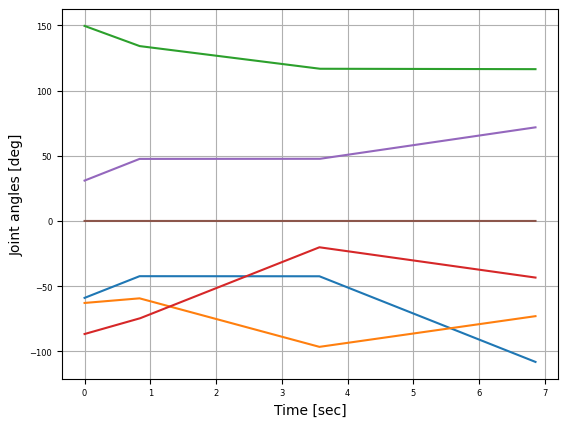

In [19]:
from model.util import get_interp_const_vel_traj

times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_pre_grasp,q_grasp,q_liftup,q_place)),vel=np.radians(20),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

plt.plot(times,np.degrees(q_traj))
plt.xlabel('Time [sec]')
plt.ylabel('Joint angles [deg]')
plt.grid(True)
plt.show()

In [20]:
def check_pose_done(env, pose):
    return np.linalg.norm((env.get_q(joint_idxs=env.ctrl_joint_idxs[0:6])-pose), ord=np.inf)

In [21]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Phase
step = 'OPEN_GRIPPER'

# Reset and initialize the joint position
env.reset() # reset
init_configuration = np.array([-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105])
env.forward(q=init_configuration,joint_idxs=env.idxs_forward)
env.update_viewer(azimuth=170,distance=0.5,lookat=env.get_p_body(body_name='tcp_link'))

# Loop
tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    # Sense
    q_rg2 = env.get_q(joint_idxs=env.ctrl_joint_idxs[6]) # joint position
    f_rg2 = env.data.qfrc_actuator[env.ctrl_joint_idxs[6]] # joint force
        
    # Step
    if step == 'OPEN_GRIPPER':
        env.step(ctrl=init_configuration,ctrl_idxs=env.idxs_step)
        env.step(ctrl=1.0,ctrl_idxs=6)
        if q_rg2 > 0.95: step = 'GOTO_GRASP'
    elif step == 'GOTO_GRASP':
        env.forward(q=q_grasp,joint_idxs=env.idxs_forward)
        env.update_viewer(azimuth=170,distance=0.5,lookat=env.get_p_body(body_name='tcp_link'))
        time_prev = env.get_sim_time()
        step = 'CLOSE_GRIPPER'
    elif step == 'CLOSE_GRIPPER':
        env.step(ctrl=q_grasp,ctrl_idxs=env.idxs_step)
        env.step(ctrl=0.0,ctrl_idxs=6)
        time_diff = env.get_sim_time() - time_prev
        if time_diff > 2.0: # after two seconds
            step = 'LIFT_UP_PLACE'
            tick_lift_up = 0
    elif step == 'LIFT_UP_PLACE':
        q = q_traj[tick_lift_up,:]
        tick_lift_up = min(tick_lift_up + 1,q_traj.shape[0]-1)
        env.step(ctrl=q,ctrl_idxs=env.idxs_step)
        if tick_lift_up == (q_traj.shape[0]-1):
            step = 'OPEN_GRIPPER2PLACE'
            q_open = env.get_q(joint_idxs=[0,1,2,3,4,5])
    elif step == 'OPEN_GRIPPER2PLACE':
        env.step(ctrl=q_open,ctrl_idxs=env.idxs_step)
        env.step(ctrl=1.0,ctrl_idxs=6)
        
    # Render
    #if (step == 'CLOSE_GRIPPER') or (step == 'LIFT_UP_PLACE') or (step == 'OPEN_GRIPPER2PLACE'):
    if (tick-1)%5 == 0:
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_base,R_base = env.get_pR_body(body_name='base')
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.render(render_every=10)
    
    # # Plot
    # if env.loop_every(HZ=1):
    #     plt.figure(figsize=(3,2))
    #     scene_img = env.grab_image()
    #     plt.imshow(scene_img)
    #     plt.title('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
    #     plt.show()
        
print ("Done.")

# Close viewer
env.close_viewer()

Done.


### Execute on Real-Robot UR5e

### Reset to Init capture pose

In [22]:
# Reset to Init capture pose
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
q = copy.deepcopy(capture_q)
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(7.0)

q_traj.points.append(point)
real_robot.execute_arm_speed(q_traj, speed_limit=1.0)
real_robot.client.wait_for_result()

graspclient = ModbusTcpClient('192.168.0.22') 
resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

q_traj_list = np.vstack((q_pre_grasp,q_grasp,q_liftup,q_place))
grasp_list = ['open', 'close', None, None, 'open']

Waiting for server...
Connected to server
[array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57]), array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57])]
[-1.57 -2.31  2.14  1.74  0.79 -1.57] [-1.57 -2.31  2.14  1.74  0.79 -1.57]
diff_q:[ 0. -0.  0. -0.  0.  0.]
diff_time:7.0
2.932419216405706e-06
Finish plan
Tool reseting


In [23]:
unit_time_base = 1.0
track_time = 0

q_curr = rospy.wait_for_message("joint_states", JointState).position
env.forward(q=q_curr,joint_idxs=idxs_forward)
x_before = env.get_p_body("tcp_link")

speed_limit = 0.20 # speed limit of joint velocity (Must be fixed to consider EE velocity instead)

resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

for i, qs in enumerate(q_traj_list):    
    q_traj = JointTrajectory()

    env.forward(q=qs,joint_idxs=idxs_forward)
    x_curr = env.get_p_body("tcp_link")
    delta_x = np.linalg.norm(x_curr - x_before)

    unit_time = max(delta_x/(speed_limit), unit_time_base)
    print(f"unit_time: {unit_time}")
    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time + 2.0)
    q_traj.points.append(point)
    
    x_before = x_curr

    real_robot.execute_arm_speed(q_traj, speed_limit=1.6)
    real_robot.client.wait_for_result()
    time.sleep(0.5)

    if grasp_list[i] is None:
        continue
    elif grasp_list[i].lower() == 'open':
        openGrasp(force=200, width=1000, graspclient=graspclient)
    elif grasp_list[i] == 'close':
        closeGrasp(force=200, width=100, graspclient=graspclient)
    else:
        raise ValueError('grasp_list must be None, open, or close')



Tool reseting
unit_time: 1.8270428395106075
Waiting for server...
Connected to server
[array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57]), array([-1.03, -1.1 ,  2.61, -1.51,  0.54, -0.  ])]
[-1.03 -1.1   2.61 -1.51  0.54 -0.  ] [-1.57 -2.31  2.14  1.74  0.79 -1.57]
diff_q:[ 0.54  1.21  0.47 -3.25 -0.24  1.57]
diff_time:3.8270428389999998
1.0152674478249462
Finish plan
unit_time: 1.0
Waiting for server...
Connected to server
[array([-1.03, -1.1 ,  2.61, -1.52,  0.54,  0.  ]), array([-0.74, -1.04,  2.34, -1.31,  0.83, -0.  ])]
[-0.74 -1.04  2.34 -1.31  0.83 -0.  ] [-1.03 -1.1   2.61 -1.52  0.54  0.  ]
diff_q:[ 0.29  0.06 -0.27  0.21  0.29 -0.  ]
diff_time:4.827042839
0.11146123066832309
Finish plan
unit_time: 1.4999986361770545
Waiting for server...
Connected to server
[array([-0.74, -1.04,  2.34, -1.31,  0.83,  0.  ]), array([-0.74, -1.69,  2.04, -0.35,  0.83, -0.  ])]
[-0.74 -1.69  2.04 -0.35  0.83 -0.  ] [-0.74 -1.04  2.34 -1.31  0.83  0.  ]
diff_q:[-0.   -0.65 -0.3   0.96 -0.   -0.  ]